# Graph Neural Networks

## Graph Convolutions 

image credits: [source](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html)

Graph convolutions operate similarly to convolutions found in machine vision models in that there is a 'filter' operation that occurs over all locations simultaneously. However, in graph convolutions, the filter operation is defined over the graph structure rather than a grid.

Graph convolutional networks operate under a message passing framework, in which nodes can exchange information with its neighbours in that they send 'messages' to one another. The first step in this process is that each node has a feature vector that is representative of the message it will pass to its neigbouring nodes. FOllowing this, the messages are pased between neighbours such that each node has received one message per neighbour. 

![image.png](graph_message_passing.svg)

As a given node may have a variable number of nodes, it is important that the function we use to combine these messages that a node has received can function regardless of the number of messages. The usual solution to this is to use the sum of the mean of the messages. 

$$H^{l+1} = \sigma (\hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}H^lW^l)$$

Where $\hat{A} = A + I$ is the adjacency matrix with self-connections added, $\hat{D}$ is the degree matrix of $\hat{A}$, $H^l$ is the matrix of node features at layer $l$, and $W^l$ is the weight matrix at layer $l$. 

$W^l$ is our weight parameters with which the input features are transformed into messages using the following expression: $H^{(l)} W^{(l)}$. $\hat{A} is the adjacency matrix $A$ added with its identity matrix such that each node also sends its own message to itself. $\hat{D}$ is the degree matrix of $\hat{A}$, which is a diagonal matrix with the degree of each node on the diagonal, this allows us to take the average. $\sigma$ is a non-linear activation function such as ReLU or tanh.

In [36]:
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torch_geometric.datasets import QM9
from torch_geometric.data import DataLoader
from torch_geometric.nn import NNConv, global_add_pool


import torch_geometric
import torch_geometric.loader as geom_data
import torch_geometric.nn as geon_nn

from pytorch_lightning.callbacks import ModelCheckpoint
from torch import Tensor

import networkx as nx
import matplotlib.pyplot as plt

In [5]:
class GCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.projection = nn.Linear(in_channels, out_channels)

    def forward(self, node_features, adj_matrix):
        num_neighbors = adj_matrix.sum(dim=-1, keepdim=True)
        node_features = self.projection(node_features)
        node_features = torch.bmm(adj_matrix, node_features)
        node_features = node_features / num_neighbors
        return node_features

Heres an example to see how this layer works by looking at how it operates on a set of node features and an adjacency matrix.

In [6]:
node_features = torch.arange(8, dtype = torch.float32).view(1,4,2)
node_features

tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])

In [7]:
adj_matrix = torch.tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]], dtype=torch.float32)

adj_matrix

tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])

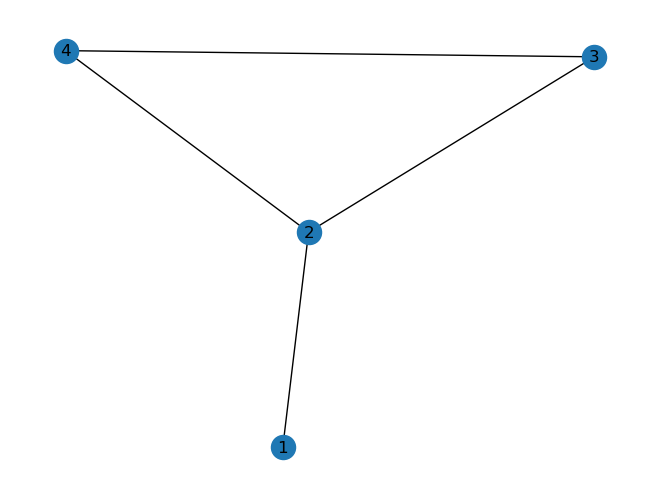

In [8]:
g = nx.Graph()
g.add_edge(1,2)
g.add_edge(2,3)
g.add_edge(3,4)
g.add_edge(2,4)
nx.draw(g, with_labels=True)

In [9]:
layer = GCNLayer(2, 2)
layer.projection.weight.data = torch.Tensor([[1., 0],  # <1>
                                             [0, 1]])

layer.projection.bias.data = torch.Tensor([0, 0])

with torch.no_grad():
    output_features = layer(node_features, adj_matrix)

output_features

tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])

1. NOte that the weight matrix in our linear layer has been set to an identity matrix. This allows us to easily examine how the message passing is occurring.

Look back at the features associated with each node and you can see that the output value is the average of its values and its neighbours values.

From this we can see that the message passing has occurred between a given node and its immediate neighbours, but it would be better if this operation could extend past the immediate neighbours. We can achieve this by using multiple GCN layers to propagate the messages further.

## Graph classification

Graph neural networks can be applied to node or edge level tasks however for chemistry graph level tasks such as graph classification seem to be most relevant so we'll look at this area for now.

![image.png](molecule_graph.svg)

We can represent molecules are graphs, in which our atoms are represented by nodes and the bonds as edges. 



In [37]:
dataset = QM9('.')

Extracting ./raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [01:32<00:00, 1442.76it/s]
Done!


In [43]:
data = dataset[0]
ys = data.y
ys.shape

torch.Size([1, 19])

In [51]:
from torch.utils.data import random_split
trainset, valset, testset = random_split(dataset, [110000, 10831, 10000])

Something to consider when using graph based approaches is how we can batch structures that can have a variable number of nodes and edges. One way you might think of is just padding every graph to be the same size as the largest but this would require alot of padding and would be inefficient. Instead we can use a technique called graph batching. In graph batching we can represent $N$ graphs as subgraphs of a a larger graph in which we have concatenated the node and edge list. As there are no connections (edges) between our subgraphs we yield the same output as we would when running our gnn across the individual graphs. 

In [67]:
train_loader = geom_data.DataLoader(
    trainset, 
    batch_size=64, 
    shuffle=True
    )

test_loader = geom_data.DataLoader(
    testset, 
    batch_size=64, 
    shuffle=False
    )

val_loader = geom_data.DataLoader(
    valset,
    batch_size=64,
    shuffle=True
    )

/home/rhysmcalister/mambaforge/envs/pyg/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [68]:
node_features = dataset.num_features
edge_features = dataset.num_edge_features

In [69]:
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [71]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, 
                 node_features, 
                 edge_features):
        super().__init__()
        torch.manual_seed(12345)
        
        conv1nn = nn.Sequential(
            nn.Linear(edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, node_features*32)
        )

        conv2nn = nn.Sequential(
            nn.Linear(edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*16)
        )

        self.conv1 = NNConv(node_features, 32, conv1nn)
        self.conv2 = NNConv(32, 16, conv2nn)
        self.fc1 = Linear(16, 32)
        self.out = nn.Linear(32, 1)
        # self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        # self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # self.conv3 = GCNConv(hidden_channels, hidden_channels)
        # self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self,data):
        batch, x, edge_index, edge_attr = (
            data.batch, data.x, data.edge_index, data.edge_attr
        )

        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        return self.out(x)
net = GCN(node_features=node_features, edge_features=edge_features)
net.to(device)
print(net)

GCN(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [76]:
epochs = 10
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
target_idx = 1

for total_epochs in range(epochs):
    
    epoch_loss = 0
    total_graphs = 0
    net.train()
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    
    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in val_loader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(output,batch.y[:, target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs
    
    
    print(f"Epochs: {total_epochs} | epoch avg. loss: {train_avg_loss:.2f} | validation avg. loss: {val_avg_loss:.2}")

Epochs: 0 | epoch avg. loss: 0.08 | validation avg. loss: 0.059
Epochs: 1 | epoch avg. loss: 0.05 | validation avg. loss: 0.039
Epochs: 2 | epoch avg. loss: 0.05 | validation avg. loss: 0.039
Epochs: 3 | epoch avg. loss: 0.04 | validation avg. loss: 0.087
Epochs: 4 | epoch avg. loss: 0.04 | validation avg. loss: 0.074
Epochs: 5 | epoch avg. loss: 0.04 | validation avg. loss: 0.031
Epochs: 6 | epoch avg. loss: 0.04 | validation avg. loss: 0.029
Epochs: 7 | epoch avg. loss: 0.04 | validation avg. loss: 0.029
Epochs: 8 | epoch avg. loss: 0.04 | validation avg. loss: 0.028
Epochs: 9 | epoch avg. loss: 0.04 | validation avg. loss: 0.03


In [79]:
net.eval()
predictions = []
real = []
import numpy as np


for batch in test_loader:
    
    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:, target_idx].detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)



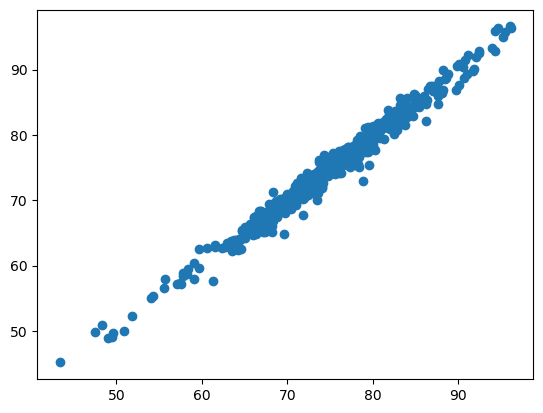

In [80]:
import matplotlib.pyplot as plt
plt.scatter(real[:500],predictions[:500])